# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

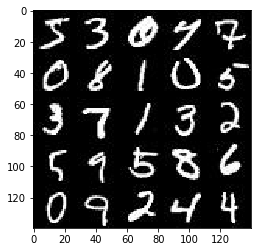

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

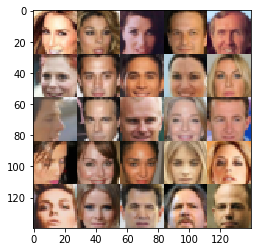

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.13.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_dim = (28, 28, 3)
    inputs_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')  
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    x = images
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        print(relu3.get_shape())

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\mrsmm\Anaconda3\envs\3.6.8\lib\site-packages\IPython\core\interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-5-1ec3448a7e9b>", line 23, in <module>
    tests.test_model_inputs(model_inputs)  File "D:\Udacity_Projects\Deep_Learning\deep-learning\face_generation\problem_unittests.py", line 14, in func_wrapper
    return result  File "D:\Udacity_Projects\Deep_Learning\deep-learning\face_generation\problem_unittests.py", line 68, in test_model_inputs
    _ch

### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        x1 = tf.layers.dense(z, units=4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum( 0.2 * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, filters=128, kernel_size=4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, filters=64, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3, filters=32, kernel_size=5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(0.2 * x4, x4)
        
        logits = tf.layers.conv2d_transpose(x4, filters=out_channel_dim, kernel_size=3, strides=1,
                                            padding='same')
        out = tf.tanh(logits)
        #print(out.get_shape())
        
    return out

    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

(?, 4, 4, 256)
(?, 4, 4, 256)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every=10 
    show_every=100
    steps = 0
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # As discriminator has generated images and real images as its input. 
                # tanh of generator outputs between -1 and +1 and as stated in problem statement, 
                # real images are normalised from -0.5 to 0.5
                batch_images = batch_images * 2
                #print("Max: {}, Min: {}".format(batch_images.min(), batch_images.min()))
                      
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    #train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(?, 4, 4, 256)
(?, 4, 4, 256)
Epoch 1/2... Discriminator Loss: 0.0030... Generator Loss: 8.0165
Epoch 1/2... Discriminator Loss: 0.0003... Generator Loss: 8.6412
Epoch 1/2... Discriminator Loss: 0.0100... Generator Loss: 6.4178
Epoch 1/2... Discriminator Loss: 5.6508... Generator Loss: 0.0083
Epoch 1/2... Discriminator Loss: 1.7966... Generator Loss: 0.4216
Epoch 1/2... Discriminator Loss: 1.7389... Generator Loss: 0.2569
Epoch 1/2... Discriminator Loss: 2.2193... Generator Loss: 0.1703
Epoch 1/2... Discriminator Loss: 2.2675... Generator Loss: 0.1795
Epoch 1/2... Discriminator Loss: 1.5983... Generator Loss: 0.3683
Epoch 1/2... Discriminator Loss: 1.7724... Generator Loss: 0.2765


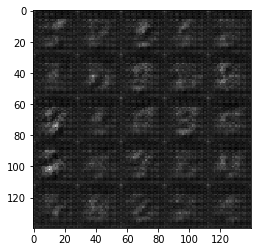

Epoch 1/2... Discriminator Loss: 1.8018... Generator Loss: 0.2422
Epoch 1/2... Discriminator Loss: 1.5275... Generator Loss: 0.3846
Epoch 1/2... Discriminator Loss: 1.5285... Generator Loss: 0.3799
Epoch 1/2... Discriminator Loss: 1.6943... Generator Loss: 0.2954
Epoch 1/2... Discriminator Loss: 1.3910... Generator Loss: 0.4018
Epoch 1/2... Discriminator Loss: 1.5980... Generator Loss: 0.2905
Epoch 1/2... Discriminator Loss: 1.2621... Generator Loss: 0.4579
Epoch 1/2... Discriminator Loss: 1.4759... Generator Loss: 0.3815
Epoch 1/2... Discriminator Loss: 1.4222... Generator Loss: 0.3649
Epoch 1/2... Discriminator Loss: 1.3344... Generator Loss: 0.4079


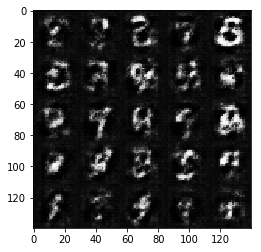

Epoch 1/2... Discriminator Loss: 1.3860... Generator Loss: 0.3959
Epoch 1/2... Discriminator Loss: 1.5349... Generator Loss: 0.3227
Epoch 1/2... Discriminator Loss: 1.6107... Generator Loss: 0.2780
Epoch 1/2... Discriminator Loss: 1.5882... Generator Loss: 0.3131
Epoch 1/2... Discriminator Loss: 1.4128... Generator Loss: 0.3527
Epoch 1/2... Discriminator Loss: 1.5443... Generator Loss: 0.2909
Epoch 1/2... Discriminator Loss: 1.5772... Generator Loss: 0.2966
Epoch 1/2... Discriminator Loss: 1.6116... Generator Loss: 0.2968
Epoch 1/2... Discriminator Loss: 1.8988... Generator Loss: 0.2001
Epoch 1/2... Discriminator Loss: 1.4432... Generator Loss: 0.3988


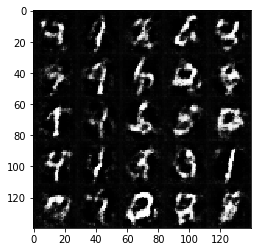

Epoch 1/2... Discriminator Loss: 2.0035... Generator Loss: 0.1736
Epoch 1/2... Discriminator Loss: 1.4518... Generator Loss: 0.3773
Epoch 1/2... Discriminator Loss: 1.5224... Generator Loss: 0.3370
Epoch 1/2... Discriminator Loss: 1.3458... Generator Loss: 0.4060
Epoch 1/2... Discriminator Loss: 1.5753... Generator Loss: 0.2980
Epoch 1/2... Discriminator Loss: 1.3486... Generator Loss: 0.4158
Epoch 1/2... Discriminator Loss: 1.6173... Generator Loss: 0.2746
Epoch 1/2... Discriminator Loss: 1.5954... Generator Loss: 0.2954
Epoch 1/2... Discriminator Loss: 1.7444... Generator Loss: 0.2484
Epoch 1/2... Discriminator Loss: 1.3399... Generator Loss: 0.4860


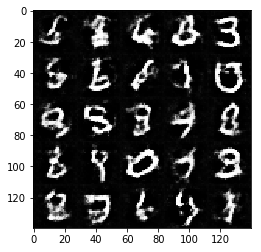

Epoch 1/2... Discriminator Loss: 1.5933... Generator Loss: 0.2928
Epoch 1/2... Discriminator Loss: 1.5043... Generator Loss: 0.3471
Epoch 1/2... Discriminator Loss: 1.2572... Generator Loss: 0.4936
Epoch 1/2... Discriminator Loss: 1.3765... Generator Loss: 0.3792
Epoch 1/2... Discriminator Loss: 1.3166... Generator Loss: 0.4493
Epoch 1/2... Discriminator Loss: 1.6878... Generator Loss: 0.2688
Epoch 1/2... Discriminator Loss: 1.1815... Generator Loss: 0.5826
Epoch 1/2... Discriminator Loss: 1.0818... Generator Loss: 1.1480
Epoch 1/2... Discriminator Loss: 1.1013... Generator Loss: 0.9647
Epoch 1/2... Discriminator Loss: 1.5374... Generator Loss: 1.7263


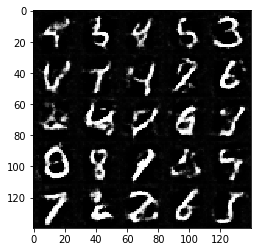

Epoch 1/2... Discriminator Loss: 1.1568... Generator Loss: 0.7328
Epoch 1/2... Discriminator Loss: 1.3122... Generator Loss: 0.4329
Epoch 1/2... Discriminator Loss: 1.4547... Generator Loss: 0.3395
Epoch 1/2... Discriminator Loss: 1.4009... Generator Loss: 0.3691
Epoch 1/2... Discriminator Loss: 1.2892... Generator Loss: 0.4872
Epoch 1/2... Discriminator Loss: 1.5970... Generator Loss: 0.2958
Epoch 1/2... Discriminator Loss: 1.9740... Generator Loss: 0.1933
Epoch 1/2... Discriminator Loss: 1.2210... Generator Loss: 0.4691
Epoch 1/2... Discriminator Loss: 1.4054... Generator Loss: 0.3625
Epoch 1/2... Discriminator Loss: 0.8258... Generator Loss: 0.9839


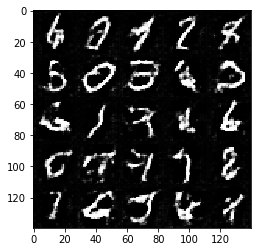

Epoch 1/2... Discriminator Loss: 1.5910... Generator Loss: 2.0398
Epoch 1/2... Discriminator Loss: 1.0547... Generator Loss: 1.0120
Epoch 1/2... Discriminator Loss: 1.5669... Generator Loss: 0.2990
Epoch 1/2... Discriminator Loss: 1.6855... Generator Loss: 0.2736
Epoch 1/2... Discriminator Loss: 1.1539... Generator Loss: 0.5737
Epoch 1/2... Discriminator Loss: 1.0954... Generator Loss: 1.4376
Epoch 1/2... Discriminator Loss: 1.2138... Generator Loss: 1.6577
Epoch 1/2... Discriminator Loss: 1.2805... Generator Loss: 0.4550
Epoch 1/2... Discriminator Loss: 1.2866... Generator Loss: 0.4413
Epoch 1/2... Discriminator Loss: 2.0710... Generator Loss: 0.1639


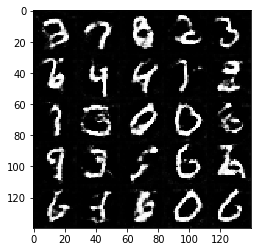

Epoch 1/2... Discriminator Loss: 1.4498... Generator Loss: 0.3626
Epoch 1/2... Discriminator Loss: 1.8709... Generator Loss: 0.2134
Epoch 1/2... Discriminator Loss: 0.9527... Generator Loss: 0.8950
Epoch 1/2... Discriminator Loss: 1.2155... Generator Loss: 1.2052
Epoch 1/2... Discriminator Loss: 0.8223... Generator Loss: 1.2245
Epoch 1/2... Discriminator Loss: 0.8102... Generator Loss: 1.0165
Epoch 1/2... Discriminator Loss: 1.3887... Generator Loss: 0.3723
Epoch 1/2... Discriminator Loss: 0.9103... Generator Loss: 1.1103
Epoch 1/2... Discriminator Loss: 2.0431... Generator Loss: 0.1662
Epoch 1/2... Discriminator Loss: 1.2985... Generator Loss: 0.4795


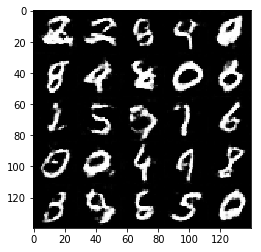

Epoch 1/2... Discriminator Loss: 1.5815... Generator Loss: 0.3023
Epoch 1/2... Discriminator Loss: 1.2135... Generator Loss: 0.4548
Epoch 1/2... Discriminator Loss: 1.1554... Generator Loss: 0.4804
Epoch 1/2... Discriminator Loss: 1.0943... Generator Loss: 0.5796
Epoch 1/2... Discriminator Loss: 1.0485... Generator Loss: 0.6231
Epoch 1/2... Discriminator Loss: 1.5032... Generator Loss: 0.3476
Epoch 1/2... Discriminator Loss: 1.1754... Generator Loss: 0.6153
Epoch 1/2... Discriminator Loss: 1.1648... Generator Loss: 0.4943
Epoch 1/2... Discriminator Loss: 1.1948... Generator Loss: 0.4942
Epoch 1/2... Discriminator Loss: 0.9172... Generator Loss: 0.8355


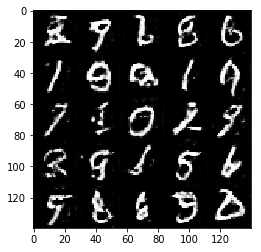

Epoch 1/2... Discriminator Loss: 1.2182... Generator Loss: 1.5312
Epoch 1/2... Discriminator Loss: 1.0637... Generator Loss: 0.6126
Epoch 1/2... Discriminator Loss: 1.0505... Generator Loss: 1.6245
Epoch 2/2... Discriminator Loss: 0.7526... Generator Loss: 1.1056
Epoch 2/2... Discriminator Loss: 0.8512... Generator Loss: 1.2425
Epoch 2/2... Discriminator Loss: 0.8139... Generator Loss: 1.1110
Epoch 2/2... Discriminator Loss: 0.9966... Generator Loss: 1.6131
Epoch 2/2... Discriminator Loss: 1.1447... Generator Loss: 1.4413
Epoch 2/2... Discriminator Loss: 1.3226... Generator Loss: 0.4310
Epoch 2/2... Discriminator Loss: 0.8818... Generator Loss: 1.4637


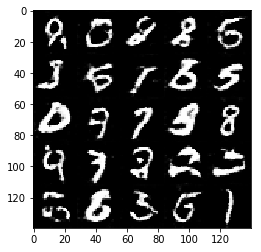

Epoch 2/2... Discriminator Loss: 0.9310... Generator Loss: 1.0718
Epoch 2/2... Discriminator Loss: 0.9260... Generator Loss: 1.3986
Epoch 2/2... Discriminator Loss: 0.6552... Generator Loss: 1.2940
Epoch 2/2... Discriminator Loss: 0.9975... Generator Loss: 0.6589
Epoch 2/2... Discriminator Loss: 1.7472... Generator Loss: 0.2661
Epoch 2/2... Discriminator Loss: 1.3531... Generator Loss: 0.4427
Epoch 2/2... Discriminator Loss: 1.5412... Generator Loss: 0.3314
Epoch 2/2... Discriminator Loss: 1.1710... Generator Loss: 0.5503
Epoch 2/2... Discriminator Loss: 0.8964... Generator Loss: 0.7258
Epoch 2/2... Discriminator Loss: 0.8001... Generator Loss: 0.9693


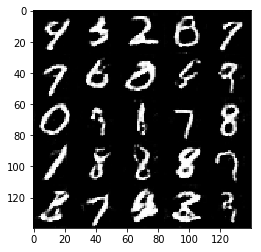

Epoch 2/2... Discriminator Loss: 1.5321... Generator Loss: 0.3927
Epoch 2/2... Discriminator Loss: 1.1735... Generator Loss: 0.5599
Epoch 2/2... Discriminator Loss: 0.8668... Generator Loss: 1.2941
Epoch 2/2... Discriminator Loss: 1.4498... Generator Loss: 0.3407
Epoch 2/2... Discriminator Loss: 1.2395... Generator Loss: 0.4467
Epoch 2/2... Discriminator Loss: 2.5280... Generator Loss: 0.1149
Epoch 2/2... Discriminator Loss: 0.7787... Generator Loss: 0.9277
Epoch 2/2... Discriminator Loss: 0.8692... Generator Loss: 1.9519
Epoch 2/2... Discriminator Loss: 0.6326... Generator Loss: 1.5240
Epoch 2/2... Discriminator Loss: 0.7612... Generator Loss: 1.4320


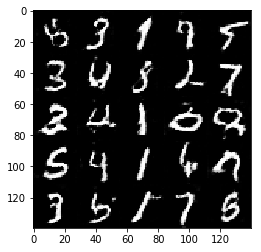

Epoch 2/2... Discriminator Loss: 1.4557... Generator Loss: 1.9067
Epoch 2/2... Discriminator Loss: 0.9963... Generator Loss: 0.7533
Epoch 2/2... Discriminator Loss: 1.7358... Generator Loss: 0.2712
Epoch 2/2... Discriminator Loss: 1.0729... Generator Loss: 0.6398
Epoch 2/2... Discriminator Loss: 0.9804... Generator Loss: 0.7011
Epoch 2/2... Discriminator Loss: 1.4676... Generator Loss: 2.1785
Epoch 2/2... Discriminator Loss: 0.8828... Generator Loss: 0.7640
Epoch 2/2... Discriminator Loss: 1.4679... Generator Loss: 0.4423
Epoch 2/2... Discriminator Loss: 1.1240... Generator Loss: 0.6380
Epoch 2/2... Discriminator Loss: 0.9121... Generator Loss: 0.8872


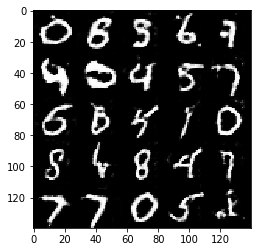

Epoch 2/2... Discriminator Loss: 1.4342... Generator Loss: 1.9746
Epoch 2/2... Discriminator Loss: 1.2882... Generator Loss: 1.8191
Epoch 2/2... Discriminator Loss: 1.7887... Generator Loss: 2.9450
Epoch 2/2... Discriminator Loss: 0.7987... Generator Loss: 1.4384
Epoch 2/2... Discriminator Loss: 1.1257... Generator Loss: 0.6163
Epoch 2/2... Discriminator Loss: 1.1529... Generator Loss: 0.6360
Epoch 2/2... Discriminator Loss: 1.1415... Generator Loss: 0.5430
Epoch 2/2... Discriminator Loss: 1.3019... Generator Loss: 0.4846
Epoch 2/2... Discriminator Loss: 1.1411... Generator Loss: 0.5621
Epoch 2/2... Discriminator Loss: 1.1704... Generator Loss: 0.5497


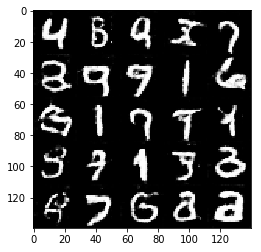

Epoch 2/2... Discriminator Loss: 1.2730... Generator Loss: 0.4725
Epoch 2/2... Discriminator Loss: 1.2232... Generator Loss: 0.4651
Epoch 2/2... Discriminator Loss: 1.0466... Generator Loss: 0.6952
Epoch 2/2... Discriminator Loss: 0.7954... Generator Loss: 1.4029
Epoch 2/2... Discriminator Loss: 0.7308... Generator Loss: 1.5837
Epoch 2/2... Discriminator Loss: 0.9382... Generator Loss: 1.9159
Epoch 2/2... Discriminator Loss: 0.9348... Generator Loss: 1.3234
Epoch 2/2... Discriminator Loss: 0.8976... Generator Loss: 0.7907
Epoch 2/2... Discriminator Loss: 1.1413... Generator Loss: 0.5100
Epoch 2/2... Discriminator Loss: 0.6999... Generator Loss: 1.1866


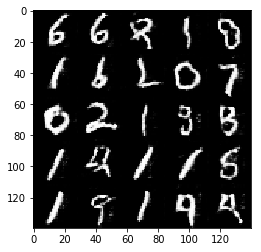

Epoch 2/2... Discriminator Loss: 1.0044... Generator Loss: 1.4458
Epoch 2/2... Discriminator Loss: 0.8168... Generator Loss: 1.1039
Epoch 2/2... Discriminator Loss: 0.5666... Generator Loss: 2.6109
Epoch 2/2... Discriminator Loss: 0.6981... Generator Loss: 2.6021
Epoch 2/2... Discriminator Loss: 0.9651... Generator Loss: 2.1917
Epoch 2/2... Discriminator Loss: 1.0863... Generator Loss: 1.1622
Epoch 2/2... Discriminator Loss: 0.9176... Generator Loss: 1.1768
Epoch 2/2... Discriminator Loss: 0.8591... Generator Loss: 1.9913
Epoch 2/2... Discriminator Loss: 0.9589... Generator Loss: 0.9703
Epoch 2/2... Discriminator Loss: 1.0538... Generator Loss: 0.6954


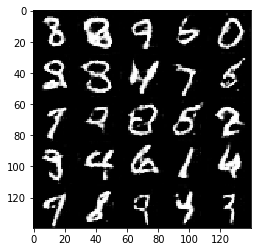

Epoch 2/2... Discriminator Loss: 1.8908... Generator Loss: 0.2160
Epoch 2/2... Discriminator Loss: 0.9908... Generator Loss: 0.7855
Epoch 2/2... Discriminator Loss: 0.8422... Generator Loss: 1.6168
Epoch 2/2... Discriminator Loss: 0.9744... Generator Loss: 1.3554
Epoch 2/2... Discriminator Loss: 0.9525... Generator Loss: 1.9538
Epoch 2/2... Discriminator Loss: 0.7991... Generator Loss: 1.6581
Epoch 2/2... Discriminator Loss: 0.7625... Generator Loss: 1.0058
Epoch 2/2... Discriminator Loss: 0.8915... Generator Loss: 1.9221
Epoch 2/2... Discriminator Loss: 0.7297... Generator Loss: 0.9905
Epoch 2/2... Discriminator Loss: 0.6451... Generator Loss: 1.5191


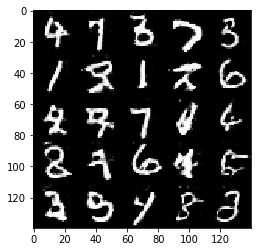

Epoch 2/2... Discriminator Loss: 0.6099... Generator Loss: 1.6578
Epoch 2/2... Discriminator Loss: 1.4187... Generator Loss: 0.4619
Epoch 2/2... Discriminator Loss: 1.0939... Generator Loss: 0.6264
Epoch 2/2... Discriminator Loss: 1.0008... Generator Loss: 0.7093
Epoch 2/2... Discriminator Loss: 0.7664... Generator Loss: 1.1323
Epoch 2/2... Discriminator Loss: 0.3570... Generator Loss: 1.7045
Epoch 2/2... Discriminator Loss: 0.8825... Generator Loss: 1.4628
Epoch 2/2... Discriminator Loss: 1.0732... Generator Loss: 0.5972
Epoch 2/2... Discriminator Loss: 0.7726... Generator Loss: 0.8282
Epoch 2/2... Discriminator Loss: 1.2255... Generator Loss: 1.9051


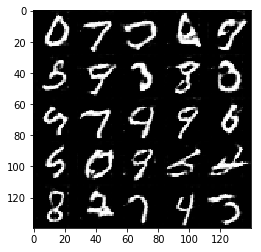

Epoch 2/2... Discriminator Loss: 0.8014... Generator Loss: 1.1620
Epoch 2/2... Discriminator Loss: 0.7083... Generator Loss: 0.9285
Epoch 2/2... Discriminator Loss: 0.7879... Generator Loss: 1.7474
Epoch 2/2... Discriminator Loss: 1.1822... Generator Loss: 0.7842
Epoch 2/2... Discriminator Loss: 1.0333... Generator Loss: 1.0982
Epoch 2/2... Discriminator Loss: 0.8651... Generator Loss: 1.7181
Epoch 2/2... Discriminator Loss: 0.8388... Generator Loss: 0.8207


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(?, 4, 4, 256)
(?, 4, 4, 256)
Epoch 1/1... Discriminator Loss: 3.4679... Generator Loss: 11.0101
Epoch 1/1... Discriminator Loss: 2.9639... Generator Loss: 10.2446
Epoch 1/1... Discriminator Loss: 1.7558... Generator Loss: 8.9521
Epoch 1/1... Discriminator Loss: 2.9012... Generator Loss: 6.5371
Epoch 1/1... Discriminator Loss: 0.9535... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 3.8660
Epoch 1/1... Discriminator Loss: 2.0614... Generator Loss: 4.8985
Epoch 1/1... Discriminator Loss: 3.3545... Generator Loss: 6.4456
Epoch 1/1... Discriminator Loss: 1.6112... Generator Loss: 0.5087
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.6501


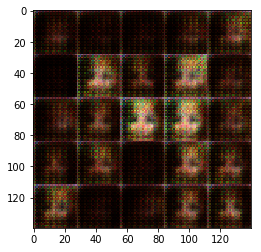

Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.4601
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 0.4842
Epoch 1/1... Discriminator Loss: 2.8162... Generator Loss: 0.0937
Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.3398
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.4069
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 1.9380
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 2.2986
Epoch 1/1... Discriminator Loss: 1.7132... Generator Loss: 2.2272
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.5492
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.4193


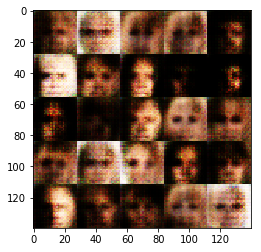

Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.4638
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.4759
Epoch 1/1... Discriminator Loss: 1.8265... Generator Loss: 0.2470
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.3882
Epoch 1/1... Discriminator Loss: 1.7447... Generator Loss: 0.2333
Epoch 1/1... Discriminator Loss: 1.6650... Generator Loss: 0.2845
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.5183
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 1.1598
Epoch 1/1... Discriminator Loss: 1.0290... Generator Loss: 1.6228
Epoch 1/1... Discriminator Loss: 1.8650... Generator Loss: 2.7618


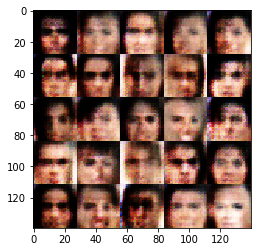

Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 1.8642
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 2.1429
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 1.7248
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 1.2782
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.5057
Epoch 1/1... Discriminator Loss: 0.8928... Generator Loss: 1.4818
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 1.6224
Epoch 1/1... Discriminator Loss: 0.9873... Generator Loss: 1.0740
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.4585


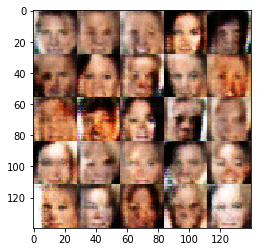

Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.3590
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.4244
Epoch 1/1... Discriminator Loss: 1.4726... Generator Loss: 1.4940
Epoch 1/1... Discriminator Loss: 2.1710... Generator Loss: 2.0812
Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 1.3973
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 1.9043... Generator Loss: 0.2814


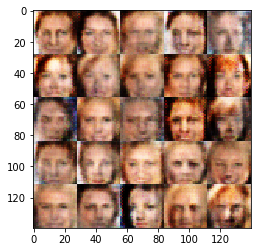

Epoch 1/1... Discriminator Loss: 1.5230... Generator Loss: 0.3676
Epoch 1/1... Discriminator Loss: 1.9820... Generator Loss: 0.1773
Epoch 1/1... Discriminator Loss: 1.5443... Generator Loss: 0.3977
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 1.6035... Generator Loss: 0.4540
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.4139
Epoch 1/1... Discriminator Loss: 1.7896... Generator Loss: 0.2334
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.3476
Epoch 1/1... Discriminator Loss: 2.2778... Generator Loss: 0.1321
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.4230


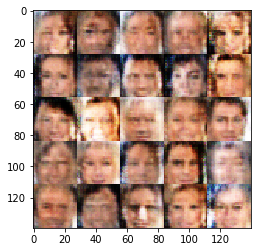

Epoch 1/1... Discriminator Loss: 1.6999... Generator Loss: 0.2948
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 1.2027
Epoch 1/1... Discriminator Loss: 1.5068... Generator Loss: 0.3537
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.3589
Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 1.0404
Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.4519
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.5331... Generator Loss: 0.3445


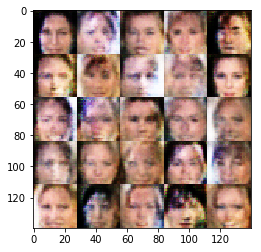

Epoch 1/1... Discriminator Loss: 2.1114... Generator Loss: 0.1565
Epoch 1/1... Discriminator Loss: 1.4890... Generator Loss: 0.3548
Epoch 1/1... Discriminator Loss: 0.6742... Generator Loss: 1.4591
Epoch 1/1... Discriminator Loss: 1.5268... Generator Loss: 0.3919
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.5728
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.3632
Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 0.3278
Epoch 1/1... Discriminator Loss: 1.5875... Generator Loss: 0.3302
Epoch 1/1... Discriminator Loss: 1.6229... Generator Loss: 0.3471


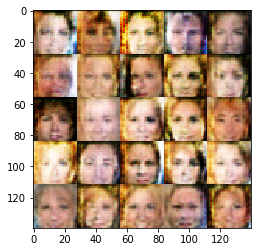

Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.5324
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.3502
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.5485
Epoch 1/1... Discriminator Loss: 1.7432... Generator Loss: 0.2632
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 2.0171
Epoch 1/1... Discriminator Loss: 1.8824... Generator Loss: 0.2106
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.4869
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.7700... Generator Loss: 0.2516


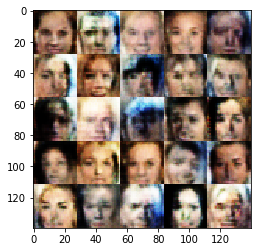

Epoch 1/1... Discriminator Loss: 1.6678... Generator Loss: 0.3105
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 1.2918
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 1.1272
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 1.0507... Generator Loss: 1.4244
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.4083
Epoch 1/1... Discriminator Loss: 1.8781... Generator Loss: 0.2013
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 1.1573
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.4659
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.4000


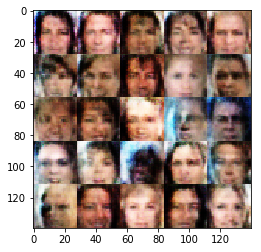

Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 1.4451
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.4527
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 1.3543
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 1.2767
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.4665
Epoch 1/1... Discriminator Loss: 1.6719... Generator Loss: 0.2655
Epoch 1/1... Discriminator Loss: 0.6839... Generator Loss: 1.1453


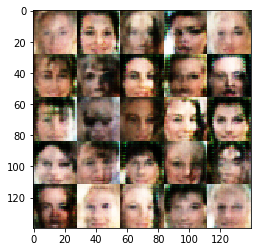

Epoch 1/1... Discriminator Loss: 1.5538... Generator Loss: 0.3961
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 0.9688
Epoch 1/1... Discriminator Loss: 1.6438... Generator Loss: 0.3342
Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.4419
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.5757... Generator Loss: 1.2049
Epoch 1/1... Discriminator Loss: 1.5964... Generator Loss: 0.3067
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.8116


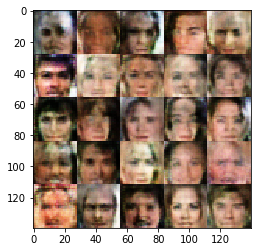

Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 0.9752
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 1.2976
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.9439... Generator Loss: 0.1876
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.7807... Generator Loss: 0.2317
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.4768
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 0.9050... Generator Loss: 1.3026


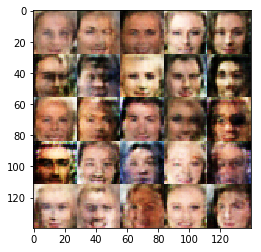

Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.9572
Epoch 1/1... Discriminator Loss: 2.0133... Generator Loss: 0.1796
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.4058
Epoch 1/1... Discriminator Loss: 1.5965... Generator Loss: 0.3054
Epoch 1/1... Discriminator Loss: 0.9090... Generator Loss: 1.6652
Epoch 1/1... Discriminator Loss: 0.9462... Generator Loss: 0.9620
Epoch 1/1... Discriminator Loss: 2.0538... Generator Loss: 0.1771
Epoch 1/1... Discriminator Loss: 1.6083... Generator Loss: 0.3218


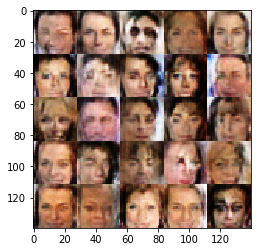

Epoch 1/1... Discriminator Loss: 1.0173... Generator Loss: 0.9069
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.4067
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.3830
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.7412... Generator Loss: 1.7590
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 1.5642
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 0.9188
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 1.0792
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 1.0571


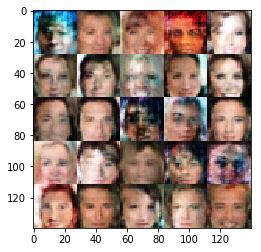

Epoch 1/1... Discriminator Loss: 1.5881... Generator Loss: 0.2872
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.4534
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 0.9433
Epoch 1/1... Discriminator Loss: 2.0497... Generator Loss: 0.1793
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.4221
Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.4666
Epoch 1/1... Discriminator Loss: 1.8519... Generator Loss: 0.2250


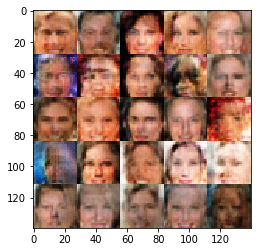

Epoch 1/1... Discriminator Loss: 1.6932... Generator Loss: 0.2875
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.5022
Epoch 1/1... Discriminator Loss: 1.9112... Generator Loss: 0.1935
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.5096
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 1.1898
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.4726
Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 1.1754
Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 1.0977


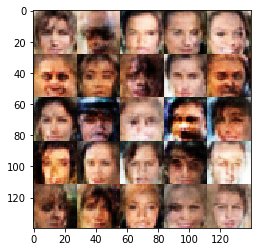

Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.4511
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 1.1136
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 1.0675
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.5474
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 0.8615
Epoch 1/1... Discriminator Loss: 1.8146... Generator Loss: 0.2242
Epoch 1/1... Discriminator Loss: 1.5704... Generator Loss: 0.3450
Epoch 1/1... Discriminator Loss: 1.6224... Generator Loss: 0.2917
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.4075


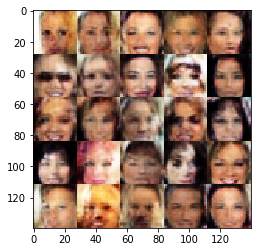

Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 0.5296
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.5209
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 1.3776
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 1.1058... Generator Loss: 1.4475
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 1.0628
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 1.1886
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.4839


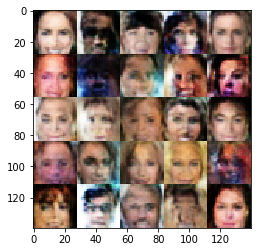

Epoch 1/1... Discriminator Loss: 0.8876... Generator Loss: 1.1406
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.5547
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.4674
Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.3759
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 1.2700
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.9631
Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 1.1074


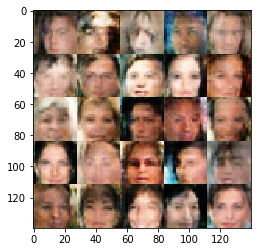

Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.4640
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.3775
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.3902
Epoch 1/1... Discriminator Loss: 1.6629... Generator Loss: 0.2978
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.4753
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.4205


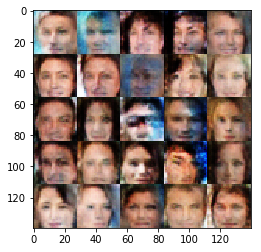

Epoch 1/1... Discriminator Loss: 1.1226... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 1.1304
Epoch 1/1... Discriminator Loss: 1.1530... Generator Loss: 1.2402
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.4163
Epoch 1/1... Discriminator Loss: 1.7167... Generator Loss: 0.2485
Epoch 1/1... Discriminator Loss: 1.7225... Generator Loss: 0.2450
Epoch 1/1... Discriminator Loss: 1.5743... Generator Loss: 0.3043
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 0.5806
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.8853


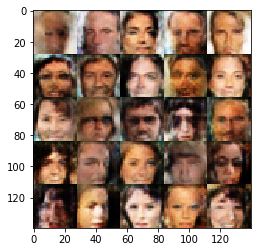

Epoch 1/1... Discriminator Loss: 0.9392... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 1.6393... Generator Loss: 0.3037
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.4370
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.3864
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.3566
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 1.5667
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.4124
Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.3119
Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 0.6978


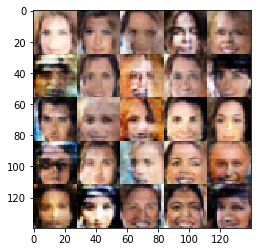

Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.4495
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 1.2537
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 1.0082
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 1.0483
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.9328
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 1.0428
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 0.7507


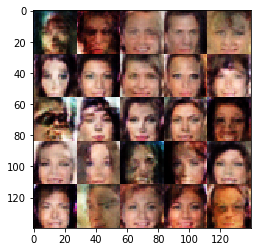

Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.3903
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.4291
Epoch 1/1... Discriminator Loss: 1.8423... Generator Loss: 1.9239
Epoch 1/1... Discriminator Loss: 1.5855... Generator Loss: 0.3061
Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 0.3313
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.3576
Epoch 1/1... Discriminator Loss: 1.5939... Generator Loss: 0.3434


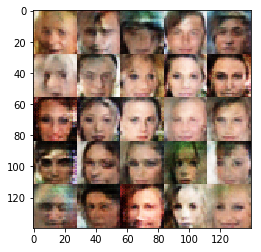

Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 1.4551
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.5067
Epoch 1/1... Discriminator Loss: 1.7326... Generator Loss: 0.2412
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 1.0246
Epoch 1/1... Discriminator Loss: 1.5621... Generator Loss: 0.3140
Epoch 1/1... Discriminator Loss: 1.6355... Generator Loss: 0.2840
Epoch 1/1... Discriminator Loss: 1.5319... Generator Loss: 0.3237
Epoch 1/1... Discriminator Loss: 1.5329... Generator Loss: 0.3510
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.3493


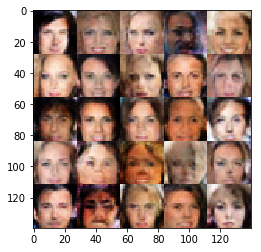

Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 0.3258
Epoch 1/1... Discriminator Loss: 1.5730... Generator Loss: 0.2965
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.3956
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 1.1754
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 1.1377
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.5221
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 1.3963


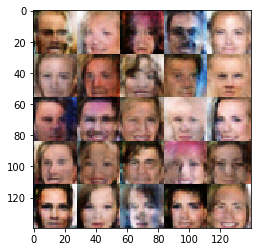

Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.7577... Generator Loss: 0.2388
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.6043... Generator Loss: 0.3022
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.9605
Epoch 1/1... Discriminator Loss: 1.0318... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.8963


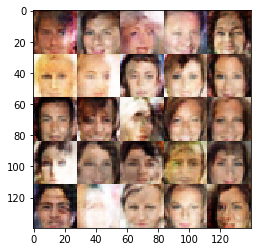

Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 1.3068
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 1.1100
Epoch 1/1... Discriminator Loss: 1.0530... Generator Loss: 0.9067
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.4922
Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 0.8910
Epoch 1/1... Discriminator Loss: 1.5876... Generator Loss: 1.5016
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.4509
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 1.1401


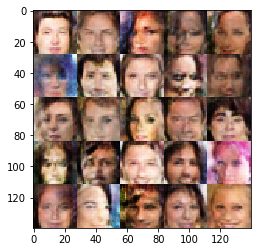

Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 1.0635
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.4697
Epoch 1/1... Discriminator Loss: 1.8950... Generator Loss: 0.2003
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 0.5765
Epoch 1/1... Discriminator Loss: 1.0384... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.5031
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 0.9657... Generator Loss: 1.0648
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.5708
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.3166


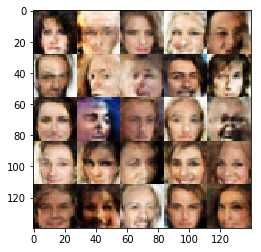

Epoch 1/1... Discriminator Loss: 1.8621... Generator Loss: 0.1972
Epoch 1/1... Discriminator Loss: 1.6196... Generator Loss: 0.3614
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 0.8635
Epoch 1/1... Discriminator Loss: 1.7812... Generator Loss: 0.2368
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.6061
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.3615
Epoch 1/1... Discriminator Loss: 1.6979... Generator Loss: 0.2670
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 1.2088
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.6099
Epoch 1/1... Discriminator Loss: 1.7734... Generator Loss: 0.2474


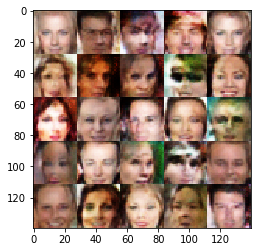

Epoch 1/1... Discriminator Loss: 1.7084... Generator Loss: 0.2622
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.5400
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.4548
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.4282
Epoch 1/1... Discriminator Loss: 1.7763... Generator Loss: 0.2345
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.4156
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 1.7886... Generator Loss: 0.2218


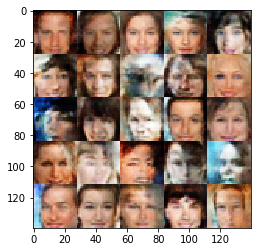

Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.5092
Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 1.2155
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.5639
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 1.1800
Epoch 1/1... Discriminator Loss: 1.5643... Generator Loss: 0.3237
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.5008
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.3560


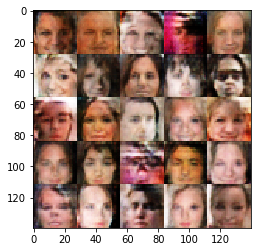

Epoch 1/1... Discriminator Loss: 1.6735... Generator Loss: 0.2603
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.3672
Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.3579
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.5618
Epoch 1/1... Discriminator Loss: 1.5288... Generator Loss: 0.3221
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.3747
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 1.6024... Generator Loss: 0.2880
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.5624


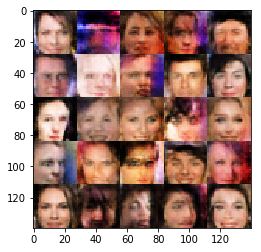

Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.3941
Epoch 1/1... Discriminator Loss: 1.7069... Generator Loss: 0.2702
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 0.6101
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.3827
Epoch 1/1... Discriminator Loss: 2.0015... Generator Loss: 0.1790
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.5026
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 1.0373
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.3864
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 1.2023


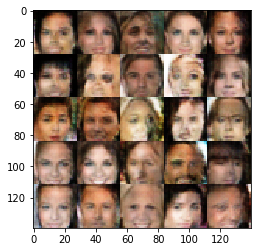

Epoch 1/1... Discriminator Loss: 0.9865... Generator Loss: 1.0868
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 0.4965
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.3651
Epoch 1/1... Discriminator Loss: 1.9686... Generator Loss: 0.1926
Epoch 1/1... Discriminator Loss: 1.5986... Generator Loss: 0.3010
Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.4324
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 1.5684
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 1.1896


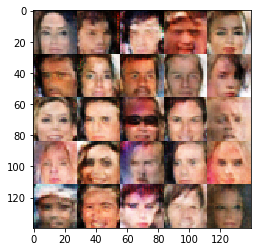

Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.4934
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 0.5449
Epoch 1/1... Discriminator Loss: 1.8434... Generator Loss: 0.2078
Epoch 1/1... Discriminator Loss: 0.9819... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.6797... Generator Loss: 0.2824
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.4023
Epoch 1/1... Discriminator Loss: 1.5486... Generator Loss: 0.3321
Epoch 1/1... Discriminator Loss: 1.7110... Generator Loss: 0.2448
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.6020


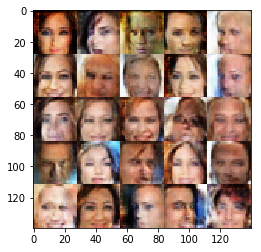

Epoch 1/1... Discriminator Loss: 1.8123... Generator Loss: 0.2126
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.4158
Epoch 1/1... Discriminator Loss: 1.5769... Generator Loss: 0.2940
Epoch 1/1... Discriminator Loss: 1.6526... Generator Loss: 0.2642
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.5200
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 1.0014... Generator Loss: 0.9372
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.5061
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.4859
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 0.9895


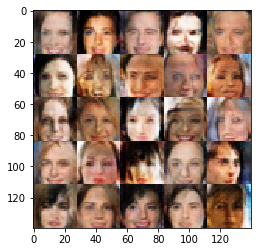

Epoch 1/1... Discriminator Loss: 1.0582... Generator Loss: 1.0610
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.9118
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 1.0405
Epoch 1/1... Discriminator Loss: 1.1313... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.4672
Epoch 1/1... Discriminator Loss: 1.6283... Generator Loss: 0.2736
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.4753
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.5236
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 0.6167


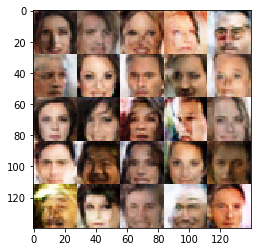

Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 1.3489
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 1.3443
Epoch 1/1... Discriminator Loss: 1.7804... Generator Loss: 0.2325
Epoch 1/1... Discriminator Loss: 1.6379... Generator Loss: 0.2982
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 1.4142
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 0.5692
Epoch 1/1... Discriminator Loss: 1.5074... Generator Loss: 0.3582
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.3914
Epoch 1/1... Discriminator Loss: 1.6274... Generator Loss: 0.2889
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 0.7293


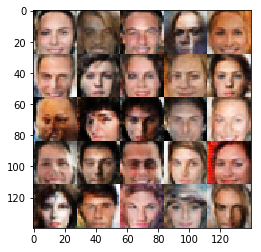

Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.3425
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.4101
Epoch 1/1... Discriminator Loss: 1.7455... Generator Loss: 0.2529
Epoch 1/1... Discriminator Loss: 1.8091... Generator Loss: 0.2244
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.4585
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.3364
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.3901
Epoch 1/1... Discriminator Loss: 1.6778... Generator Loss: 0.3079
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 1.1430
Epoch 1/1... Discriminator Loss: 1.8716... Generator Loss: 0.2315


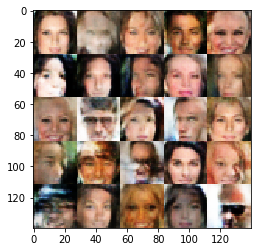

Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 1.1897
Epoch 1/1... Discriminator Loss: 0.9442... Generator Loss: 0.9635
Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 0.3667
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.4144
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.4882
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.3525
Epoch 1/1... Discriminator Loss: 1.5835... Generator Loss: 0.3029
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 0.9035... Generator Loss: 1.0534


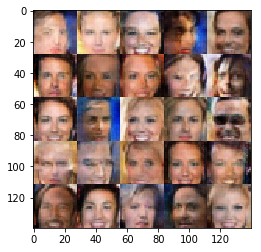

Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 0.5485
Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 1.1034... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 0.9122... Generator Loss: 0.8353
Epoch 1/1... Discriminator Loss: 1.6222... Generator Loss: 0.3090
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.7054... Generator Loss: 0.2368
Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 0.7410


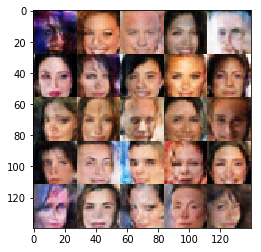

Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 1.0379
Epoch 1/1... Discriminator Loss: 1.5336... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.4162
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.5572
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 1.3360
Epoch 1/1... Discriminator Loss: 1.8218... Generator Loss: 0.2124
Epoch 1/1... Discriminator Loss: 1.6804... Generator Loss: 0.2802
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 1.1917
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.3960


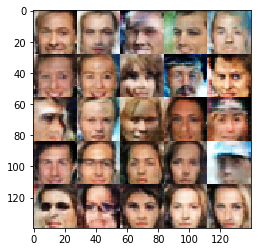

Epoch 1/1... Discriminator Loss: 1.5864... Generator Loss: 0.2813
Epoch 1/1... Discriminator Loss: 1.5227... Generator Loss: 0.3384
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.4897
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 1.3015
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.3555
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.4590
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.5175
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 1.2603


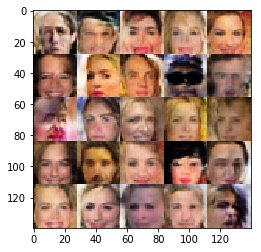

Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 1.2393
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 1.1282
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 1.0817
Epoch 1/1... Discriminator Loss: 0.9921... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.4715
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 0.5986


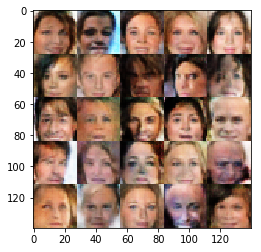

Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 1.1063
Epoch 1/1... Discriminator Loss: 1.1799... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.4340
Epoch 1/1... Discriminator Loss: 1.5230... Generator Loss: 0.3323
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.6106
Epoch 1/1... Discriminator Loss: 1.7110... Generator Loss: 0.2833
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.4781
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.4155
Epoch 1/1... Discriminator Loss: 1.9680... Generator Loss: 0.1790
Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 0.8236


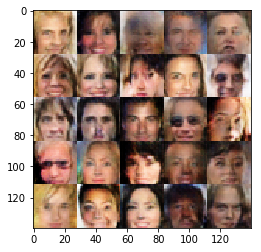

Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.4477
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.3913
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.5706
Epoch 1/1... Discriminator Loss: 0.9759... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 0.5501
Epoch 1/1... Discriminator Loss: 1.8540... Generator Loss: 0.2472
Epoch 1/1... Discriminator Loss: 1.5222... Generator Loss: 0.3248
Epoch 1/1... Discriminator Loss: 1.5246... Generator Loss: 0.3375


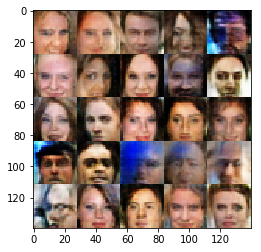

Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.5765... Generator Loss: 0.2972
Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 0.4839
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 1.1102
Epoch 1/1... Discriminator Loss: 1.6374... Generator Loss: 0.2905
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.5188
Epoch 1/1... Discriminator Loss: 1.6930... Generator Loss: 0.2676
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 0.8769
Epoch 1/1... Discriminator Loss: 0.9438... Generator Loss: 0.8245
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.3842


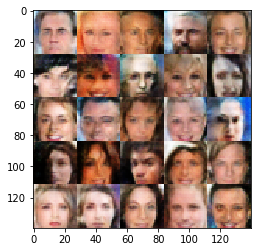

Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.7293... Generator Loss: 0.2743
Epoch 1/1... Discriminator Loss: 1.6970... Generator Loss: 0.2432
Epoch 1/1... Discriminator Loss: 1.5492... Generator Loss: 0.4201
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.4484
Epoch 1/1... Discriminator Loss: 1.5580... Generator Loss: 0.3059
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.5306
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 1.1159
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.7943


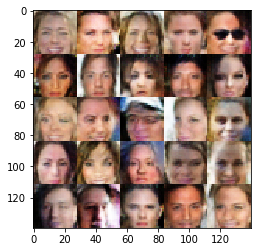

Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 1.0041
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.4275
Epoch 1/1... Discriminator Loss: 1.5264... Generator Loss: 0.3545
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.3526
Epoch 1/1... Discriminator Loss: 1.6146... Generator Loss: 0.3605
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.4311
Epoch 1/1... Discriminator Loss: 1.6429... Generator Loss: 0.3055
Epoch 1/1... Discriminator Loss: 1.7073... Generator Loss: 0.2627
Epoch 1/1... Discriminator Loss: 1.6088... Generator Loss: 0.2918


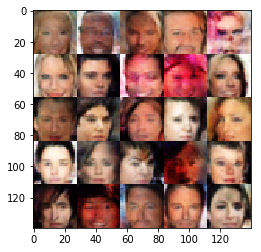

Epoch 1/1... Discriminator Loss: 1.9839... Generator Loss: 0.1920
Epoch 1/1... Discriminator Loss: 1.6070... Generator Loss: 0.3103
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 1.5114
Epoch 1/1... Discriminator Loss: 1.7311... Generator Loss: 0.2770
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 0.5249
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.4719
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.0614... Generator Loss: 1.0929
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.6249... Generator Loss: 0.2870


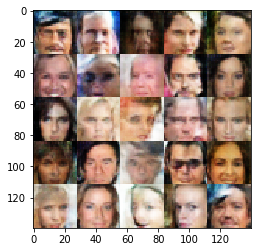

Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.3543
Epoch 1/1... Discriminator Loss: 1.5214... Generator Loss: 0.3422
Epoch 1/1... Discriminator Loss: 1.8440... Generator Loss: 0.2182
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.3675
Epoch 1/1... Discriminator Loss: 1.7195... Generator Loss: 0.2498
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.4142
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.4863


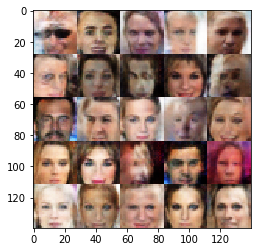

Epoch 1/1... Discriminator Loss: 1.7780... Generator Loss: 0.2182
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.6981... Generator Loss: 0.2923
Epoch 1/1... Discriminator Loss: 1.6541... Generator Loss: 0.2862
Epoch 1/1... Discriminator Loss: 1.7204... Generator Loss: 0.2634
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.3601
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.4199
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.4884
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 1.0243
Epoch 1/1... Discriminator Loss: 0.8934... Generator Loss: 1.1048


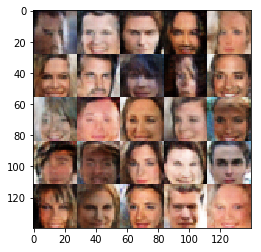

Epoch 1/1... Discriminator Loss: 1.0332... Generator Loss: 1.0601
Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.3181
Epoch 1/1... Discriminator Loss: 1.8507... Generator Loss: 0.2256
Epoch 1/1... Discriminator Loss: 1.7729... Generator Loss: 0.2392
Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 1.1786
Epoch 1/1... Discriminator Loss: 1.5671... Generator Loss: 0.3218
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 0.6309
Epoch 1/1... Discriminator Loss: 1.8398... Generator Loss: 0.2083
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.4103
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.6193


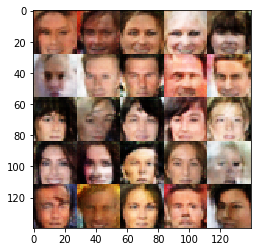

Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.3735
Epoch 1/1... Discriminator Loss: 1.5462... Generator Loss: 0.3405
Epoch 1/1... Discriminator Loss: 1.6493... Generator Loss: 0.2813
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.4256
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.3818
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.3380
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.4997
Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.4331


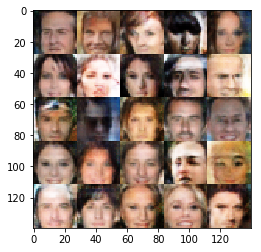

Epoch 1/1... Discriminator Loss: 1.5631... Generator Loss: 0.3393
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.4434
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 1.2795
Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 1.2533
Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.4330
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.3444
Epoch 1/1... Discriminator Loss: 1.0830... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.7560... Generator Loss: 0.2320


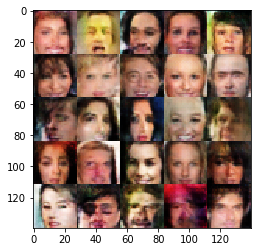

Epoch 1/1... Discriminator Loss: 1.6343... Generator Loss: 0.2848
Epoch 1/1... Discriminator Loss: 1.0598... Generator Loss: 0.9790
Epoch 1/1... Discriminator Loss: 1.6137... Generator Loss: 0.2922
Epoch 1/1... Discriminator Loss: 1.5270... Generator Loss: 0.2929
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.3485
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.4170
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 1.0447
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 0.8915
Epoch 1/1... Discriminator Loss: 1.0107... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.7750... Generator Loss: 0.2250


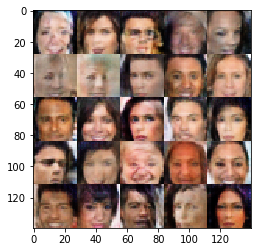

Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.5013
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.4779
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.3782
Epoch 1/1... Discriminator Loss: 0.9767... Generator Loss: 1.0252
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.6300
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 0.5933
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.5837


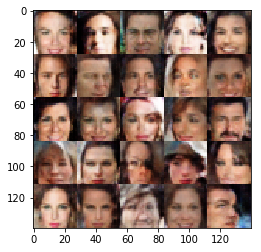

Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 1.4269
Epoch 1/1... Discriminator Loss: 1.5803... Generator Loss: 0.2986
Epoch 1/1... Discriminator Loss: 1.5994... Generator Loss: 0.3329
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 1.0226
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.3493
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.3159
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.4029
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 0.7208


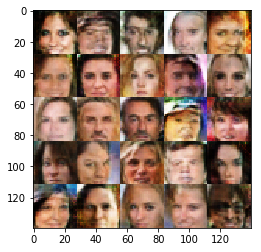

Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.5006
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.3401
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.5410
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.5604
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.5196... Generator Loss: 0.3195
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 0.9284
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 1.3742


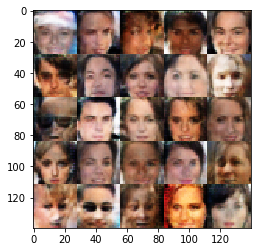

Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.4717
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 1.8624
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.4976
Epoch 1/1... Discriminator Loss: 1.1208... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.5682
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.3977
Epoch 1/1... Discriminator Loss: 1.7357... Generator Loss: 0.2520
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.3466
Epoch 1/1... Discriminator Loss: 0.9514... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.4608


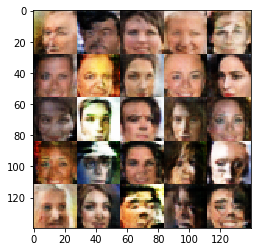

Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 0.3004
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.4956
Epoch 1/1... Discriminator Loss: 1.5739... Generator Loss: 0.3123
Epoch 1/1... Discriminator Loss: 0.9532... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 0.5201
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 1.0545... Generator Loss: 1.2621
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.4394
Epoch 1/1... Discriminator Loss: 1.4950... Generator Loss: 0.3916
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.9329


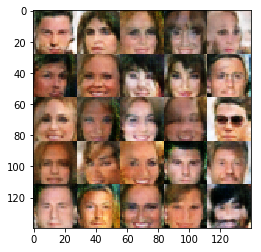

Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.7892... Generator Loss: 0.2686
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 0.6211


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.